In [7]:
!pip install pandas-datareader

   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   ---------------------------------------- 3.8/3.8 MB 17.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import datetime, timedelta
import time

Error downloading data for NOVO.US: 'Close'


C:\Users\44790\AppData\Local\Temp\ipykernel_16504\1799337493.py:62: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = all_data.pct_change()
C:\Users\44790\AppData\Local\Temp\ipykernel_16504\1799337493.py:77: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = portfolio_returns.resample('M').sum()


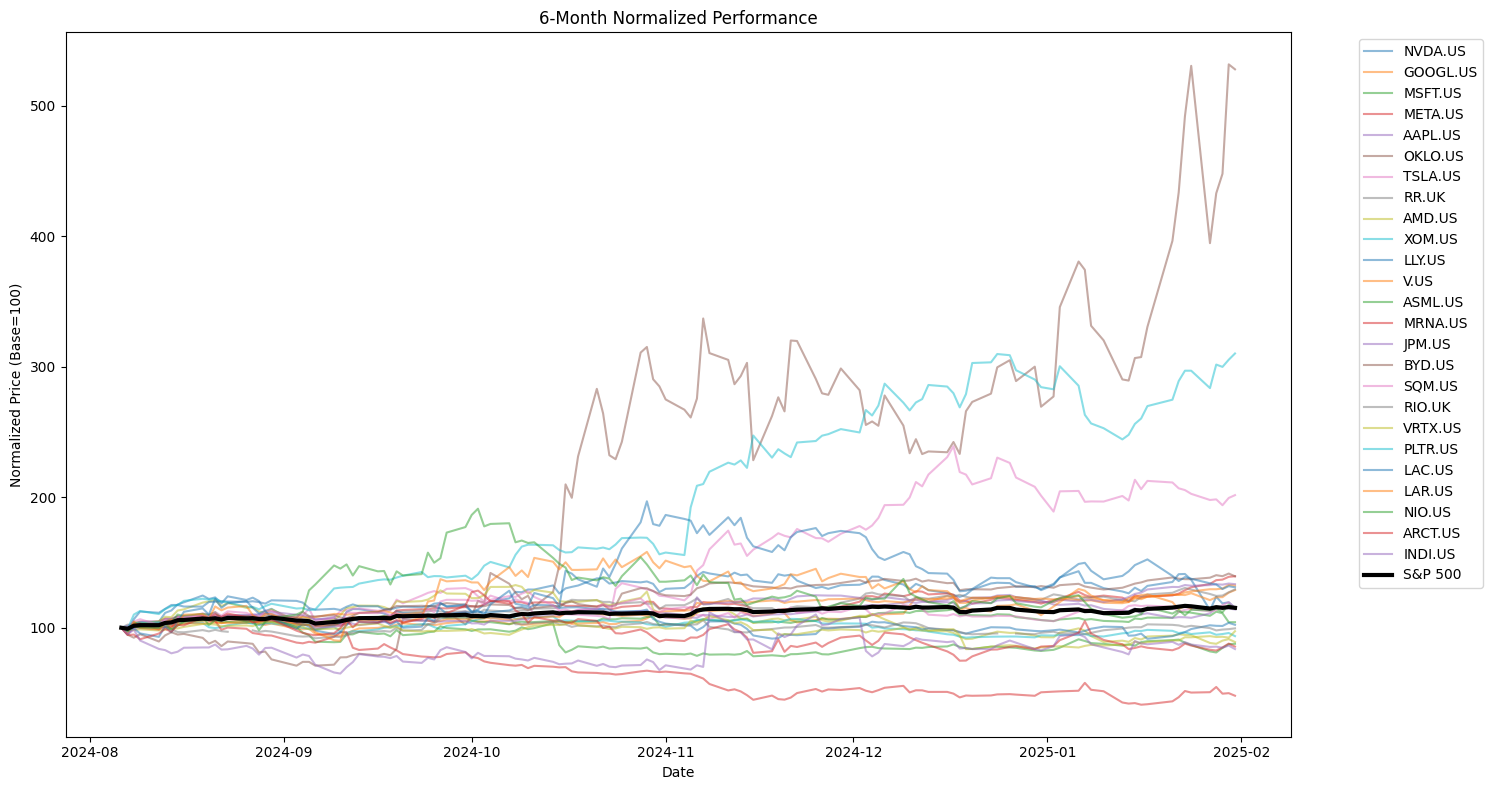

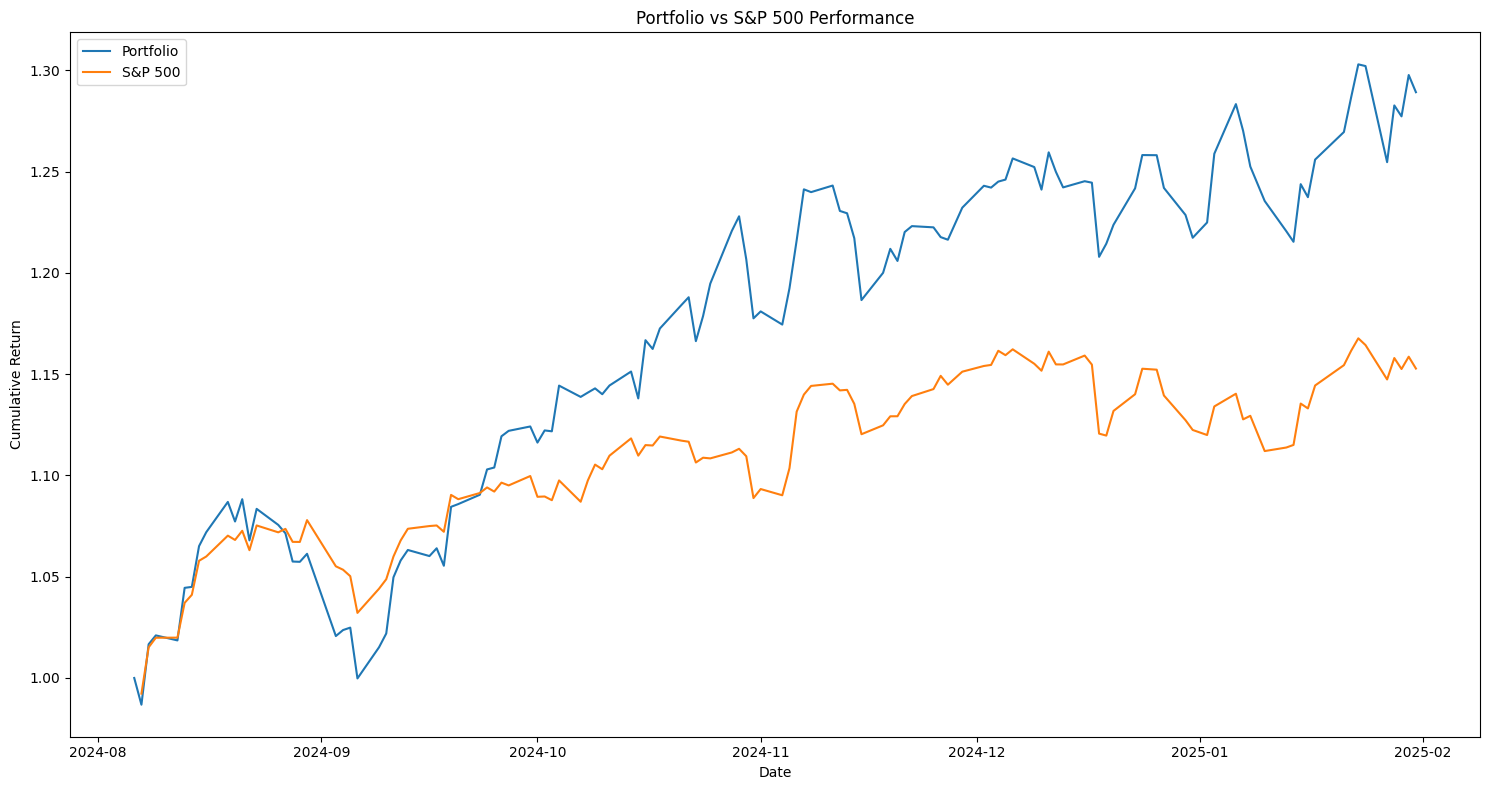

<Figure size 1500x800 with 0 Axes>

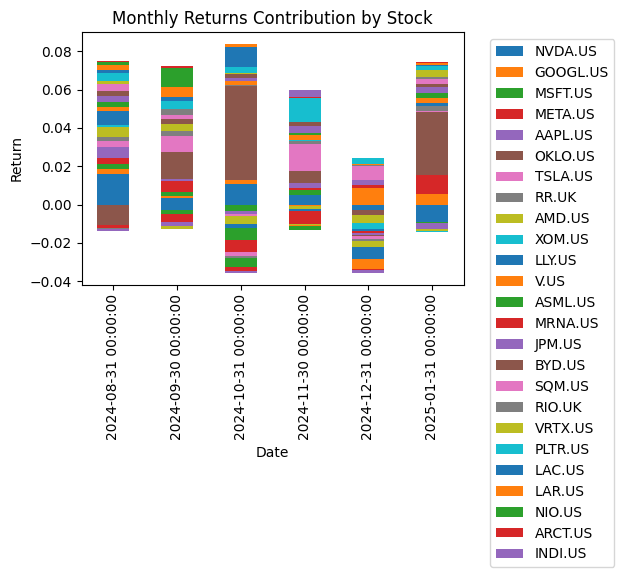

In [13]:


# Portfolio composition
portfolio = {
    'NVDA.US': 0.1089,
    'GOOGL.US': 0.0723,
    'MSFT.US': 0.0591,
    'META.US': 0.0587,
    'AAPL.US': 0.0567,
    'OKLO.US': 0.0402,
    'TSLA.US': 0.0402,
    'RR.UK': 0.0375,
    'AMD.US': 0.0363,
    'XOM.US': 0.0351,
    'LLY.US': 0.0347,
    'V.US': 0.0340,
    'ASML.US': 0.0316,
    'MRNA.US': 0.0304,
    'JPM.US': 0.0304,
    'BYD.US': 0.0302,
    'SQM.US': 0.0282,
    'RIO.UK': 0.0259,
    'VRTX.US': 0.0252,
    'PLTR.US': 0.0236,
    'LAC.US': 0.0216,
    'LAR.US': 0.0205,
    #'PLS.AX': 0.0203,
    'NIO.US': 0.0184,
    'NOVO.US': 0.018,
    'ARCT.US': 0.0085,
    'INDI.US': 0.0059
    #'PMET.V': 0.0044,
    #'LTR.AX': 0.0021
}

def get_portfolio_performance():
    # Set date range
    end_date = datetime.now()
    start_date = end_date - timedelta(days=180)
    
    # Initialize DataFrame for stock prices
    all_data = pd.DataFrame()
    
    # Download data for S&P 500 as benchmark
    try:
        spy = web.DataReader('^SPX', 'stooq', start_date, end_date)['Close']
        spy = spy.sort_index()  # Stooq returns data in reverse order
    except Exception as e:
        print(f"Error downloading S&P 500 data: {e}")
        return None
    
    # Download data for each stock with rate limiting
    for ticker in portfolio.keys():
        try:
            print(f"Downloading data for {ticker}")
            stock_data = web.DataReader(ticker, 'stooq', start_date, end_date)['Close']
            stock_data = stock_data.sort_index()
            all_data[ticker] = stock_data
            time.sleep(1)  # Rate limiting
        except Exception as e:
            print(f"Error downloading data for {ticker}: {e}")
    
    # Calculate daily returns
    daily_returns = all_data.pct_change()
    
    # Calculate portfolio returns
    portfolio_returns = pd.DataFrame()
    for ticker in portfolio.keys():
        if ticker in daily_returns.columns:
            portfolio_returns[ticker] = daily_returns[ticker] * portfolio[ticker]
    
    portfolio_total_returns = portfolio_returns.sum(axis=1)
    
    # Normalize prices for comparison
    normalized_prices = all_data / all_data.iloc[0] * 100
    normalized_spy = spy / spy.iloc[0] * 100
    
    # Calculate monthly returns with contribution
    monthly_returns = portfolio_returns.resample('M').sum()
    
    return normalized_prices, normalized_spy, monthly_returns, portfolio_total_returns

def plot_normalized_performance(normalized_prices, normalized_spy):
    plt.figure(figsize=(15, 8))
    for col in normalized_prices.columns:
        plt.plot(normalized_prices.index, normalized_prices[col], label=col, alpha=0.5)
    plt.plot(normalized_spy.index, normalized_spy, label='S&P 500', linewidth=3, color='black')
    plt.title('6-Month Normalized Performance')
    plt.xlabel('Date')
    plt.ylabel('Normalized Price (Base=100)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_portfolio_vs_benchmark(portfolio_total_returns, spy_returns):
    plt.figure(figsize=(15, 8))
    cumulative_portfolio = (1 + portfolio_total_returns).cumprod()
    cumulative_spy = (1 + spy_returns.pct_change()).cumprod()
    
    plt.plot(cumulative_portfolio.index, cumulative_portfolio, label='Portfolio')
    plt.plot(cumulative_spy.index, cumulative_spy, label='S&P 500')
    plt.title('Portfolio vs S&P 500 Performance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_monthly_contributions(monthly_returns):
    plt.figure(figsize=(15, 8))
    monthly_returns.plot(kind='bar', stacked=True)
    plt.title('Monthly Returns Contribution by Stock')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Run the analysis
if __name__ == "__main__":
    results = get_portfolio_performance()
    if results is not None:
        normalized_prices, normalized_spy, monthly_returns, portfolio_total_returns = results
        plot_normalized_performance(normalized_prices, normalized_spy)
        plot_portfolio_vs_benchmark(portfolio_total_returns, normalized_spy)
        plot_monthly_contributions(monthly_returns)